# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


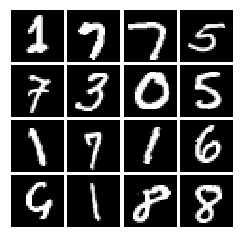

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU  
    
    return tf.maximum(x, alpha*x)

Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    
    return tf.random_uniform([batch_size, dim], minval=-1, maxval=1)

Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture

        # Implementation 1
        fc1 = tf.layers.dense(x, units=256, activation=leaky_relu, use_bias=True)
        fc2 = tf.layers.dense(fc1, units=256, activation=leaky_relu, use_bias=True)
        fc3 = tf.layers.dense(fc2, units=1, use_bias=True)
        
        # Implementation 2
        #fc1 = tf.layers.dense(x, units=256, use_bias=True)
        #relu1 = leaky_relu(fc1, alpha=0.01)
        #fc2 = tf.layers.dense(relu1, units=256, use_bias=True)
        #relu2 = leaky_relu(fc2, alpha=0.01)
        #fc3 = tf.layers.dense(relu2, units=1, use_bias=True)        
        
        logits = fc3
        
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        fc1 = tf.layers.dense(z, units=1024, activation=tf.nn.relu, use_bias=True)
        fc2 = tf.layers.dense(fc1, units=1024, activation=tf.nn.relu, use_bias=True)
        fc3 = tf.layers.dense(fc2, units=784, activation=tf.nn.tanh, use_bias=True)
        
        img = fc3
        
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None        
    
    # GENERATOR
    # Generator tries to make discrimator output 1 for all images
    # Average loss over batch
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
    G_loss = tf.reduce_mean(G_loss)
    
    # DISCRIMINATOR
    # Discriminator loss has 2 parts
    # 1: How well it classifies real images
    # 2: How well it classifies fake images
    # Add losses & average over batch
    D_loss1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
    D_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)   
    D_loss = D_loss1 + D_loss2
    D_loss = tf.reduce_mean(D_loss)
     
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None

    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

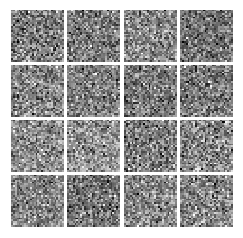


Iter: 0, D: 1.222, G:0.7608
Iter: 50, D: 0.3234, G:1.911
Iter: 100, D: 1.943, G:1.29
Iter: 150, D: 1.412, G:1.18
Iter: 200, D: 1.386, G:1.042


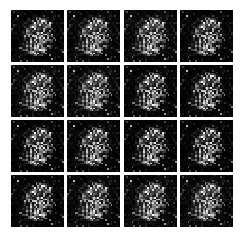


Iter: 250, D: 1.107, G:2.16
Iter: 300, D: 1.183, G:1.09
Iter: 350, D: 1.409, G:0.9707
Iter: 400, D: 0.9709, G:1.14
Iter: 450, D: 0.8969, G:1.53


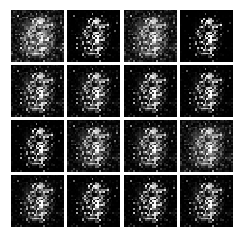


Iter: 500, D: 1.172, G:1.22
Iter: 550, D: 0.9676, G:1.959
Iter: 600, D: 1.233, G:1.632
Iter: 650, D: 1.143, G:2.114
Iter: 700, D: 1.367, G:0.6903


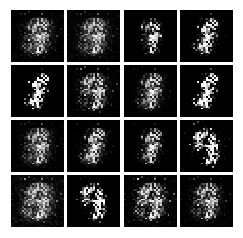


Iter: 750, D: 1.465, G:0.9744
Iter: 800, D: 1.03, G:1.156
Iter: 850, D: 1.175, G:1.407
Iter: 900, D: 1.259, G:0.2065
Iter: 950, D: 1.475, G:0.8909


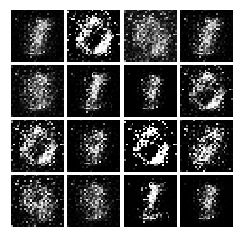


Iter: 1000, D: 1.0, G:1.164
Iter: 1050, D: 1.375, G:1.126
Iter: 1100, D: 1.564, G:1.345
Iter: 1150, D: 1.265, G:1.067
Iter: 1200, D: 1.236, G:0.9153


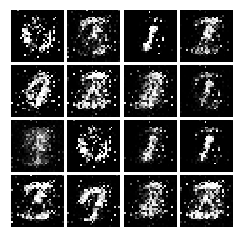


Iter: 1250, D: 1.098, G:3.185
Iter: 1300, D: 1.322, G:2.617
Iter: 1350, D: 1.366, G:0.3125
Iter: 1400, D: 1.347, G:1.099
Iter: 1450, D: 1.222, G:1.049


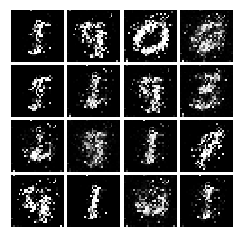


Iter: 1500, D: 1.086, G:1.352
Iter: 1550, D: 1.328, G:1.331
Iter: 1600, D: 1.194, G:1.087
Iter: 1650, D: 1.134, G:1.226
Iter: 1700, D: 1.321, G:1.427


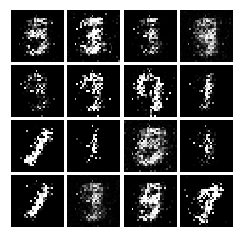


Iter: 1750, D: 1.297, G:0.9799
Iter: 1800, D: 1.33, G:0.8399
Iter: 1850, D: 1.342, G:0.9569
Iter: 1900, D: 1.179, G:1.048
Iter: 1950, D: 1.227, G:1.07


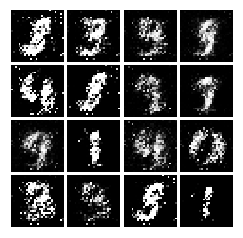


Iter: 2000, D: 1.282, G:0.8108
Iter: 2050, D: 1.302, G:1.104
Iter: 2100, D: 1.276, G:1.122
Iter: 2150, D: 1.275, G:0.8979
Iter: 2200, D: 1.258, G:0.8518


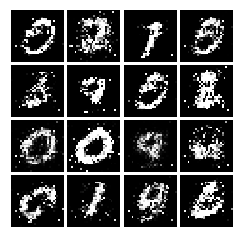


Iter: 2250, D: 1.404, G:0.7926
Iter: 2300, D: 1.273, G:0.8716
Iter: 2350, D: 1.259, G:0.9684
Iter: 2400, D: 1.324, G:0.8471
Iter: 2450, D: 1.386, G:1.031


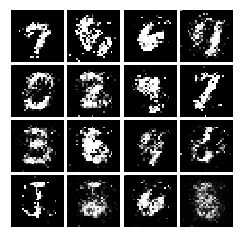


Iter: 2500, D: 1.33, G:0.9919
Iter: 2550, D: 1.317, G:0.8479
Iter: 2600, D: 1.441, G:0.9028
Iter: 2650, D: 2.259, G:0.07779
Iter: 2700, D: 1.279, G:0.8213


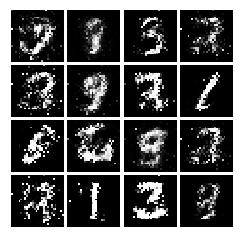


Iter: 2750, D: 1.374, G:0.7624
Iter: 2800, D: 1.269, G:0.8226
Iter: 2850, D: 1.309, G:0.7999
Iter: 2900, D: 1.224, G:0.9151
Iter: 2950, D: 1.269, G:0.7986


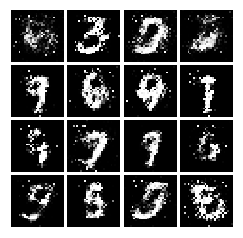


Iter: 3000, D: 1.355, G:0.8489
Iter: 3050, D: 1.354, G:0.7369
Iter: 3100, D: 1.399, G:0.6622
Iter: 3150, D: 1.346, G:0.8225
Iter: 3200, D: 1.261, G:1.078


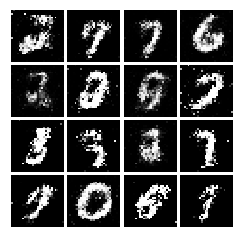


Iter: 3250, D: 1.372, G:0.8531
Iter: 3300, D: 1.352, G:0.7768
Iter: 3350, D: 1.432, G:0.7962
Iter: 3400, D: 1.365, G:0.8755
Iter: 3450, D: 1.411, G:0.7946


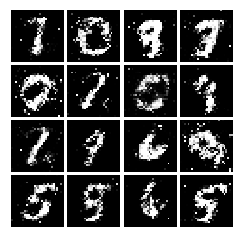


Iter: 3500, D: 1.285, G:0.823
Iter: 3550, D: 1.343, G:0.8122
Iter: 3600, D: 1.314, G:0.8584
Iter: 3650, D: 1.381, G:0.8179
Iter: 3700, D: 1.323, G:0.8369


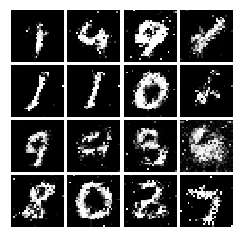


Iter: 3750, D: 1.367, G:0.7543
Iter: 3800, D: 1.315, G:0.7548
Iter: 3850, D: 1.315, G:0.7874
Iter: 3900, D: 1.338, G:0.7275
Iter: 3950, D: 1.238, G:1.04


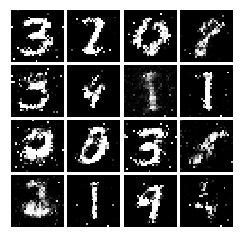


Iter: 4000, D: 1.38, G:0.7708
Iter: 4050, D: 1.344, G:0.833
Iter: 4100, D: 1.313, G:0.7944
Iter: 4150, D: 1.377, G:0.7641
Iter: 4200, D: 1.302, G:0.785


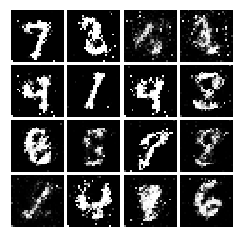


Iter: 4250, D: 1.371, G:0.9052
Final images


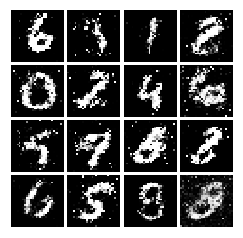

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [17]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    
    # GENERATOR
    G_loss = tf.pow(score_fake - 1, 2)
    G_loss = 0.5 * tf.reduce_mean(G_loss)
    
    # DISCRIMINATOR
    # Discriminator loss has 2 parts
    D_loss1 = tf.pow(score_real - 1, 2)
    D_loss1 = tf.reduce_mean(D_loss1)

    D_loss2 = tf.pow(score_fake, 2)
    D_loss2 = tf.reduce_mean(D_loss2)
    
    D_loss = 0.5 * (D_loss1 + D_loss2)
    
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [18]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [19]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

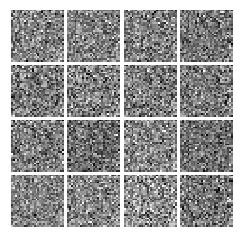


Iter: 0, D: 0.6795, G:0.3965
Iter: 50, D: 0.04358, G:0.8488
Iter: 100, D: 0.01152, G:0.595
Iter: 150, D: 0.03406, G:0.5972
Iter: 200, D: 0.9556, G:0.06581


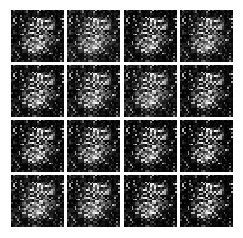


Iter: 250, D: 0.0897, G:0.3855
Iter: 300, D: 0.2, G:0.6163
Iter: 350, D: 0.09433, G:0.3705
Iter: 400, D: 0.05202, G:0.9341
Iter: 450, D: 0.1488, G:0.4111


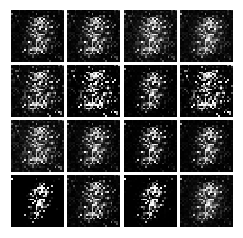


Iter: 500, D: 0.1864, G:0.301
Iter: 550, D: 0.1297, G:0.279
Iter: 600, D: 0.1801, G:0.2735
Iter: 650, D: 0.1425, G:0.4472
Iter: 700, D: 0.1613, G:0.4337


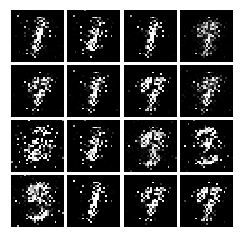


Iter: 750, D: 0.1099, G:0.2897
Iter: 800, D: 0.1582, G:0.4133
Iter: 850, D: 0.1181, G:0.4322
Iter: 900, D: 0.1027, G:0.4641
Iter: 950, D: 0.1587, G:0.3741


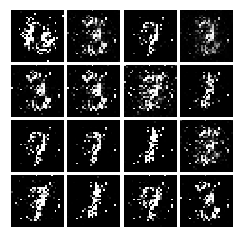


Iter: 1000, D: 0.1327, G:0.2983
Iter: 1050, D: 0.121, G:0.4012
Iter: 1100, D: 0.09323, G:0.7413
Iter: 1150, D: 0.1421, G:0.4836
Iter: 1200, D: 0.1436, G:0.638


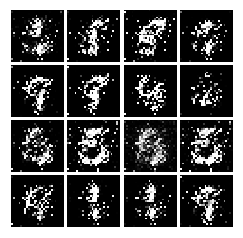


Iter: 1250, D: 0.1322, G:0.2208
Iter: 1300, D: 0.1676, G:0.2786
Iter: 1350, D: 0.1317, G:0.4652
Iter: 1400, D: 0.1611, G:0.2458
Iter: 1450, D: 0.169, G:0.3066


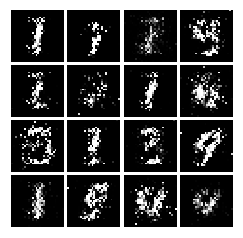


Iter: 1500, D: 0.1506, G:0.3636
Iter: 1550, D: 0.2283, G:0.1979
Iter: 1600, D: 0.2146, G:0.2008
Iter: 1650, D: 0.1919, G:0.2017
Iter: 1700, D: 0.1967, G:0.1825


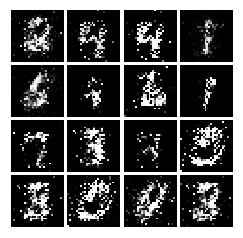


Iter: 1750, D: 0.2036, G:0.2057
Iter: 1800, D: 0.208, G:0.2094
Iter: 1850, D: 0.2119, G:0.2206
Iter: 1900, D: 0.2081, G:0.1938
Iter: 1950, D: 0.1957, G:0.2007


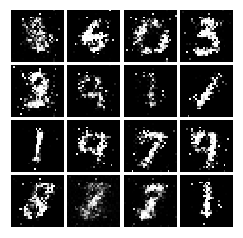


Iter: 2000, D: 0.2093, G:0.1653
Iter: 2050, D: 0.2283, G:0.1909
Iter: 2100, D: 0.2078, G:0.2006
Iter: 2150, D: 0.2161, G:0.2318
Iter: 2200, D: 0.2384, G:0.1796


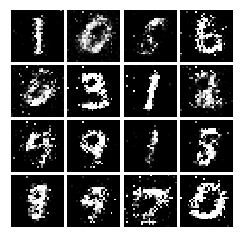


Iter: 2250, D: 0.2508, G:0.1699
Iter: 2300, D: 0.2214, G:0.1823
Iter: 2350, D: 0.2276, G:0.1765
Iter: 2400, D: 0.2114, G:0.1495
Iter: 2450, D: 0.2327, G:0.1908


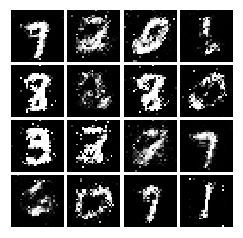


Iter: 2500, D: 0.2045, G:0.1926
Iter: 2550, D: 0.2215, G:0.1884
Iter: 2600, D: 0.228, G:0.1935
Iter: 2650, D: 0.2072, G:0.186
Iter: 2700, D: 0.2438, G:0.1718


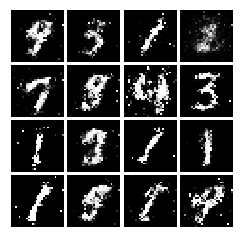


Iter: 2750, D: 0.2235, G:0.1677
Iter: 2800, D: 0.2324, G:0.1679
Iter: 2850, D: 0.2021, G:0.2028
Iter: 2900, D: 0.2222, G:0.1885
Iter: 2950, D: 0.2305, G:0.2068


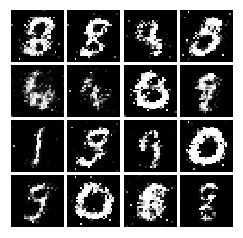


Iter: 3000, D: 0.2224, G:0.1342
Iter: 3050, D: 0.2089, G:0.177
Iter: 3100, D: 0.2196, G:0.1795
Iter: 3150, D: 0.2359, G:0.2122
Iter: 3200, D: 0.2247, G:0.1921


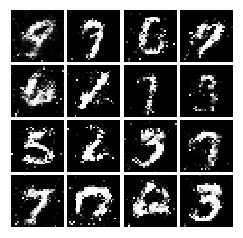


Iter: 3250, D: 0.2366, G:0.1822
Iter: 3300, D: 0.2226, G:0.2025
Iter: 3350, D: 0.2252, G:0.1746
Iter: 3400, D: 0.2306, G:0.1679
Iter: 3450, D: 0.2337, G:0.1749


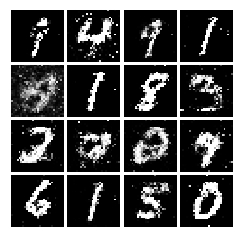


Iter: 3500, D: 0.23, G:0.1761
Iter: 3550, D: 0.2211, G:0.1593
Iter: 3600, D: 0.2308, G:0.1816
Iter: 3650, D: 0.2243, G:0.1718
Iter: 3700, D: 0.2096, G:0.1616


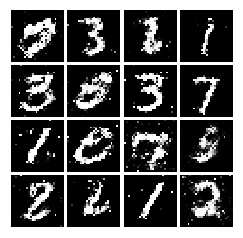


Iter: 3750, D: 0.2253, G:0.1757
Iter: 3800, D: 0.2309, G:0.1968
Iter: 3850, D: 0.2224, G:0.1664
Iter: 3900, D: 0.1995, G:0.1828
Iter: 3950, D: 0.2251, G:0.175


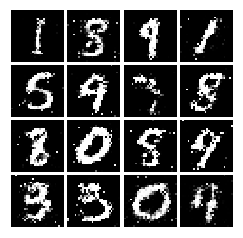


Iter: 4000, D: 0.228, G:0.1932
Iter: 4050, D: 0.2199, G:0.1701
Iter: 4100, D: 0.2307, G:0.1591
Iter: 4150, D: 0.222, G:0.1513
Iter: 4200, D: 0.223, G:0.1663


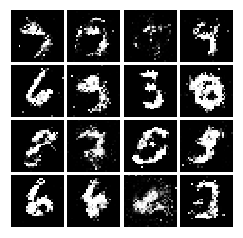


Iter: 4250, D: 0.229, G:0.156
Final images


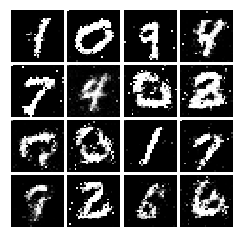

In [20]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

At the beginning of training, the samples look similar to each other - indicating a similarity in distribution as there is not much variation. As training continues, variation increases and so too does the image quality compared to the typical GAN trained earlier.

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [21]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        # Reshape input from [N, D] to [N, H, W, C]
        x = tf.reshape(x, shape=[-1,28,28,1])

        # (Conv - LReLU - Max_Pool) * 2
        conv1 = tf.layers.conv2d(x, filters=32, strides=[1,1], kernel_size=[5,5])
        L_relu1 = leaky_relu(conv1, alpha=0.01)
        pool1 = tf.layers.max_pooling2d(L_relu1, pool_size=[2,2], strides=2)
        
        conv2 = tf.layers.conv2d(pool1, filters=64, strides=[1,1], kernel_size=5, activation=leaky_relu)
        L_relu2 = leaky_relu(conv2, alpha=0.01)
        pool2 = tf.layers.max_pooling2d(L_relu2, pool_size=[2,2], strides=2)
        
        # Reshape to [N, D] and pass through fully-connected layers
        flat1 = tf.reshape(pool2, shape=[-1, 1024])
        fc1 = tf.layers.dense(flat1, units=1024)
        L_relu3 = leaky_relu(fc1, alpha=0.01)
        
        fc2 = tf.layers.dense(L_relu3, units=1)
        
        logits = fc2
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [22]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        # (Fully-connected - Batch_norm) * 2
        fc1 = tf.layers.dense(z, units=1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        
        fc2 = tf.layers.dense(bn1, units=6272, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        
        # Reshape from [N, D] to [N, H, W, C]
        reshape = tf.reshape(bn2, shape=[-1,7,7,128])
        
        # conv2D.T - Batch_norm - conv2D.T
        conv1_T = tf.layers.conv2d_transpose(reshape, filters=64, kernel_size=[4,4], strides=[2,2],
                                             activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(conv1_T, training=True)       
        conv2_T = tf.layers.conv2d_transpose(bn3, filters=1, kernel_size=[4,4], strides=[2,2],
                                             activation=tf.nn.tanh, padding='same')
        
        # Reshape to [N,D]
        flat1 = tf.reshape(conv2_T, shape=[-1, 784])
        
        img = flat1
        
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [23]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

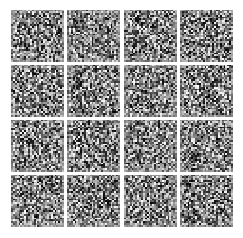


Iter: 0, D: 1.386, G:0.5414
Iter: 50, D: 1.78, G:3.912
Iter: 100, D: 1.183, G:2.851
Iter: 150, D: 1.033, G:0.8936
Iter: 200, D: 1.069, G:1.041


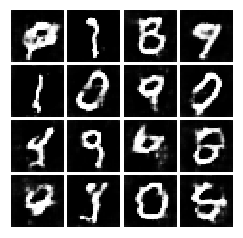


Iter: 250, D: 1.255, G:0.8793
Iter: 300, D: 1.121, G:0.8791
Iter: 350, D: 1.112, G:0.8143
Iter: 400, D: 1.206, G:1.289
Iter: 450, D: 1.161, G:0.8939


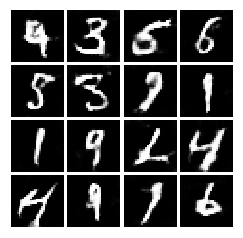


Iter: 500, D: 1.139, G:0.8675
Iter: 550, D: 1.161, G:0.9366
Iter: 600, D: 1.23, G:0.8699
Iter: 650, D: 1.438, G:0.8478
Iter: 700, D: 1.154, G:0.8446


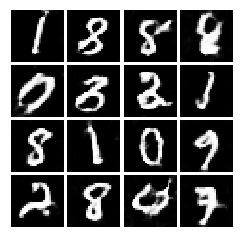


Iter: 750, D: 1.129, G:0.7725
Iter: 800, D: 1.267, G:0.8738
Iter: 850, D: 1.181, G:0.7974
Iter: 900, D: 1.347, G:1.323
Iter: 950, D: 1.197, G:0.8124


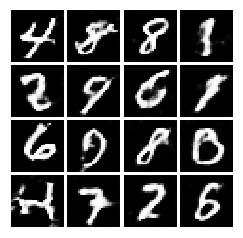


Iter: 1000, D: 1.169, G:0.8477
Iter: 1050, D: 1.06, G:0.9249
Iter: 1100, D: 1.078, G:1.062
Iter: 1150, D: 1.201, G:1.234
Iter: 1200, D: 1.146, G:0.6676


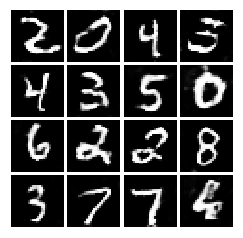


Iter: 1250, D: 1.37, G:0.6758
Iter: 1300, D: 1.243, G:0.9285
Iter: 1350, D: 1.127, G:1.057
Iter: 1400, D: 1.282, G:0.793
Iter: 1450, D: 1.214, G:0.9425


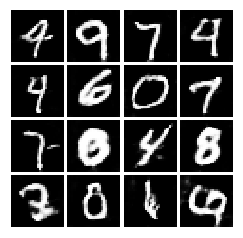


Iter: 1500, D: 1.316, G:0.562
Iter: 1550, D: 1.145, G:1.008
Iter: 1600, D: 1.176, G:0.7485
Iter: 1650, D: 1.341, G:0.7042
Iter: 1700, D: 1.158, G:1.088


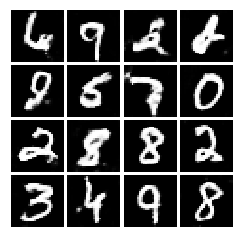


Iter: 1750, D: 1.086, G:0.9521
Iter: 1800, D: 1.122, G:0.9555
Iter: 1850, D: 1.178, G:0.9651
Iter: 1900, D: 1.105, G:1.52
Iter: 1950, D: 1.231, G:0.9338


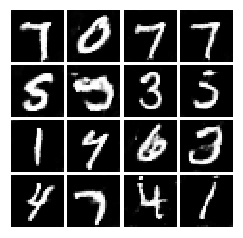


Iter: 2000, D: 1.057, G:0.9019
Iter: 2050, D: 1.087, G:0.913
Iter: 2100, D: 1.167, G:1.51
Final images


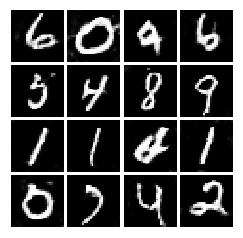

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

DCGAN images are much cleaner, crisper, and less noisy compared to the original GAN and LS-GAN images. Lines are more solid (rather than random white pixels) - the DCGAN convolutional network gives it this ability to produce 'sharp edges'. DCGAN images look very similar to MNIST.

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [25]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
              
        # Reshape input to [N,H,W,C]
        x = tf.reshape(x, shape=[-1,28,28,1])
        
        conv1 = tf.layers.conv2d(x, filters=64, kernel_size=[4,4], strides=[2,2],
                                 activation=leaky_relu, padding='valid')
        conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=4, strides=2,
                                 activation=leaky_relu, padding='valid')
        bn1 = tf.layers.batch_normalization(conv2)
        
        # Reshape to [N,D]
        flat = tf.reshape(bn1, shape=[-1, 3200])
        fc1 = tf.layers.dense(flat, units=1024, activation=leaky_relu)
        fc2 = tf.layers.dense(fc1, units=1)
        
        logits = fc2
        
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [26]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [27]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake - logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1], minval=0, maxval=1)
    x_hat = tf.reshape(G_sample, [batch_size,-1])
    x_hat = (eps * x) + (1 - eps) * x_hat

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        D_x_hat = discriminator(x_hat)
        grad_D_x_hat = tf.gradients(D_x_hat, x_hat)[0]
        
    grad_norm = tf.norm(grad_D_x_hat, axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))

    D_loss += lam * grad_pen
    
    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

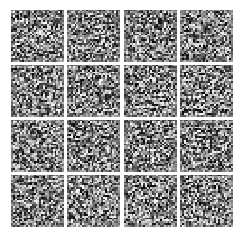


Iter: 0, D: 8.376, G:-0.2868
Iter: 50, D: -5.589, G:-16.25
Iter: 100, D: -1.227, G:-14.6
Iter: 150, D: -0.3573, G:-3.434
Iter: 200, D: -0.8611, G:-11.33


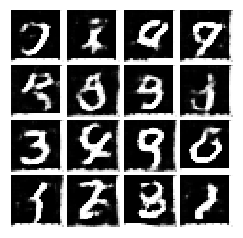


Iter: 250, D: -1.413, G:-13.62
Iter: 300, D: 0.1386, G:-3.908
Iter: 350, D: -0.01171, G:-13.14
Iter: 400, D: -1.352, G:-16.26
Iter: 450, D: -0.08589, G:-4.572


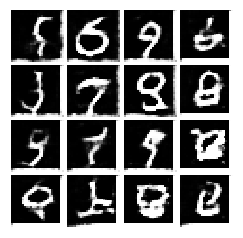


Iter: 500, D: -0.6561, G:-3.456
Iter: 550, D: -0.2453, G:-6.955
Iter: 600, D: -0.6408, G:-5.541
Iter: 650, D: 0.2083, G:0.008291
Iter: 700, D: 0.09188, G:-10.39


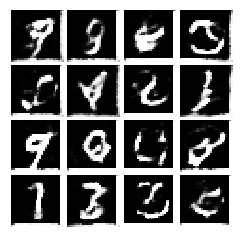


Iter: 750, D: -0.2045, G:-2.443
Iter: 800, D: -0.6914, G:-7.865
Iter: 850, D: -1.248, G:10.05
Iter: 900, D: -0.09799, G:-2.728
Iter: 950, D: -0.02506, G:-12.36


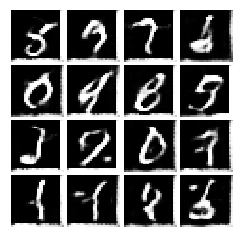


Iter: 1000, D: -0.9669, G:7.253
Iter: 1050, D: -0.1277, G:-11.18
Iter: 1100, D: 0.2507, G:-3.87
Iter: 1150, D: -0.4014, G:-3.339
Iter: 1200, D: -0.1239, G:-10.32


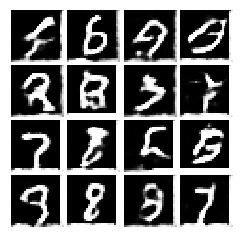


Iter: 1250, D: -1.232, G:-10.05
Iter: 1300, D: 0.004998, G:-0.9233
Iter: 1350, D: -0.8092, G:-8.78
Iter: 1400, D: -0.974, G:-12.67
Iter: 1450, D: -0.545, G:-2.03


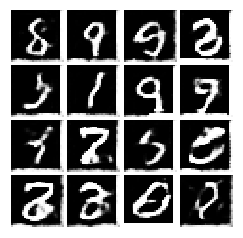


Iter: 1500, D: -0.189, G:-7.124
Iter: 1550, D: 0.01572, G:-9.853
Iter: 1600, D: -0.8782, G:-8.609
Iter: 1650, D: -0.0891, G:-10.87
Iter: 1700, D: -0.7145, G:-0.1595


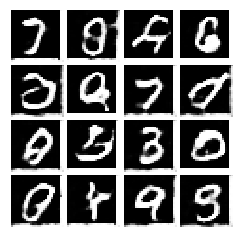


Iter: 1750, D: -0.8637, G:-1.54
Iter: 1800, D: -0.05322, G:-6.765
Iter: 1850, D: -0.3995, G:-6.816
Iter: 1900, D: -0.4604, G:2.982
Iter: 1950, D: 0.2511, G:-2.505


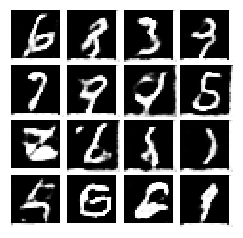


Iter: 2000, D: -0.04055, G:-8.943
Iter: 2050, D: -0.2885, G:-12.45
Iter: 2100, D: -0.3615, G:7.731
Final images


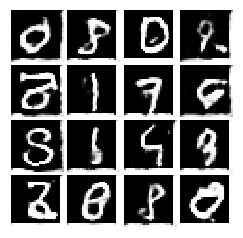

In [28]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)